In [1]:
import functools
import glob
import os

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy import stats

In [3]:
import lib

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc9/texlive/2024/bin/x86_64-linux"

In [5]:
shear_step_plus = 'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'
shear_step_minus = 'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'

In [6]:
shear_step = shear_step_plus

In [7]:
match_catalogs = {
    shear_step: os.path.join(
        "/pscratch/sd/s/smau/y6-image-sims-matches",
        f"match_{shear_step}.hdf5",
    )
    for shear_step in lib.const.SHEAR_STEPS
}

In [8]:
hf_imsim = h5py.File(lib.const.IMSIM_CATALOGS[shear_step])
hf_redshift = h5py.File(lib.const.REDSHIFT_CATALOGS[shear_step])
hf_match = h5py.File(match_catalogs[shear_step])

In [10]:
zbinsc = hf_redshift["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]

zc = np.concatenate([[0.0], zbinsc])

nz_sompz = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz_p = hf_redshift["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_p = np.concatenate([[0.0], _nz_p])
    
    _nz_p = _nz_p / np.asarray(lib.util.sompz_integral(_nz_p, zc, 0, 6.0))
    
    
    _nz_m = hf_redshift["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_m = np.concatenate([[0.0], _nz_m])
    
    _nz_m = _nz_m / np.asarray(lib.util.sompz_integral(_nz_m, zc, 0, 6.0))

    
    nz_sompz[tomographic_bin] = (_nz_p + _nz_m) / 2 
    
nz_sompz[-1] = (nz_sompz[0] + nz_sompz[1] + nz_sompz[2] + nz_sompz[3]) / 4

In [11]:
bhat = lib.tomography.get_tomography(
    hf_imsim,
    hf_redshift,
    "noshear",
)

In [13]:
assignments = {
    mdet_step: lib.tomography.get_assignment(
        hf_imsim,
        hf_redshift,
        mdet_step,
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [14]:
statistical_weights = {
    mdet_step: lib.weights.get_shear_weights(
        hf_imsim["mdet"][mdet_step],
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [15]:
g1 = {
    mdet_step: hf_imsim["mdet"][mdet_step]["gauss_g_1"][:]
    for mdet_step in lib.const.MDET_STEPS
}

g2 = {
    mdet_step: hf_imsim["mdet"][mdet_step]["gauss_g_2"][:]
    for mdet_step in lib.const.MDET_STEPS
}

In [16]:
_count, _, _ = stats.binned_statistic(
    assignments["noshear"],
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)

count_grid = _count

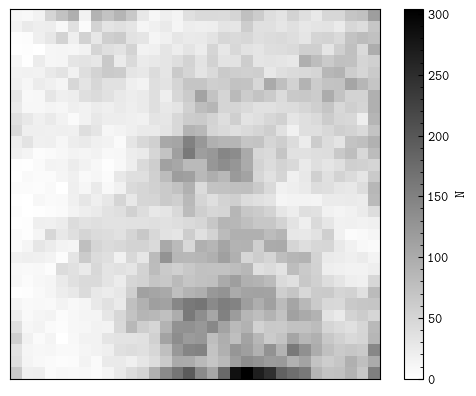

In [17]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    count_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
fig.colorbar(m, label="$N$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [18]:
# response grid
mean_g_1 = {}
mean_g_2 = {}
for mdet_step in ["1p", "1m"]:
    _sum_weight, _, _ = stats.binned_statistic(
        assignments[mdet_step],
        statistical_weights[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g_1, _, _ = stats.binned_statistic(
        assignments[mdet_step],
        statistical_weights[mdet_step] * g1[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g_1[mdet_step] = _sum_g_1 / _sum_weight

    _sum_g_2, _, _ = stats.binned_statistic(
        assignments[mdet_step],
        statistical_weights[mdet_step] * g2[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g_2[mdet_step] = _sum_g_2 / _sum_weight

response_grid = (mean_g_1["1p"] - mean_g_1["1m"]) / (2 * 0.01)


/tmp/ipykernel_672650/717252187.py:18: RuntimeWarning: invalid value encountered in divide
  mean_g_1[mdet_step] = _sum_g_1 / _sum_weight
/tmp/ipykernel_672650/717252187.py:26: RuntimeWarning: invalid value encountered in divide
  mean_g_2[mdet_step] = _sum_g_2 / _sum_weight


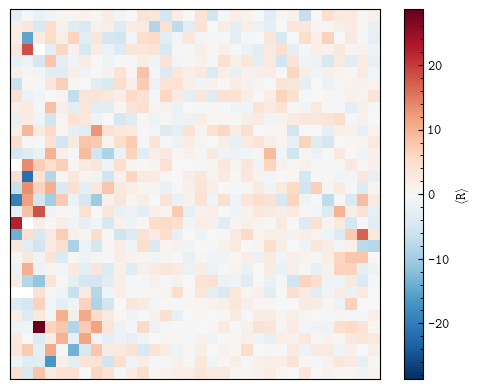

In [19]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    response_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
)
fig.colorbar(m, label="$\\langle R \\rangle$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [20]:
weight_grid, _, _ = stats.binned_statistic(
    assignments["noshear"],
    statistical_weights["noshear"],
    statistic="sum",
    bins=lib.const.CELL_IDS,
)

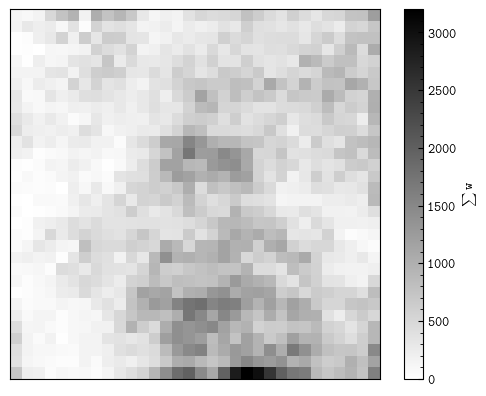

In [21]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    weight_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
fig.colorbar(m, label="$\\sum w$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

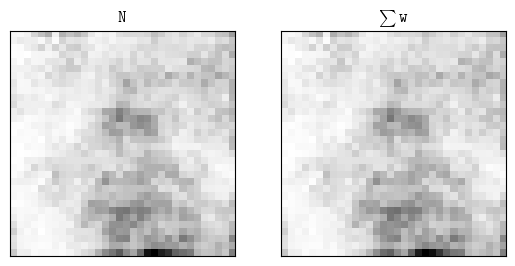

In [22]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(
    count_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
axs[0].set_title("$N$")

axs[1].imshow(
    weight_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
axs[1].set_title("$\\sum w$")

for ax  in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

---

In [23]:
match_indices = ~np.isnan(hf_match["mdet"]["uid"])

In [111]:
# extend the last bin and "pileup"
zedges = np.copy(lib.const.ZEDGES)
zedges[-1] = 4.

_sum_weight, _, _, _ = stats.binned_statistic_2d(
    assignments["noshear"][match_indices],
    hf_match["mdet"]["z"][match_indices],
    statistical_weights["noshear"][match_indices],
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

nz = _sum_weight / np.diff(lib.const.ZEDGES)
nz /= nz.sum()

/tmp/ipykernel_672650/999526811.py:5: RuntimeWarning: invalid value encountered in divide
  np.sum(lib.const.ZVALS * nz, axis=1)


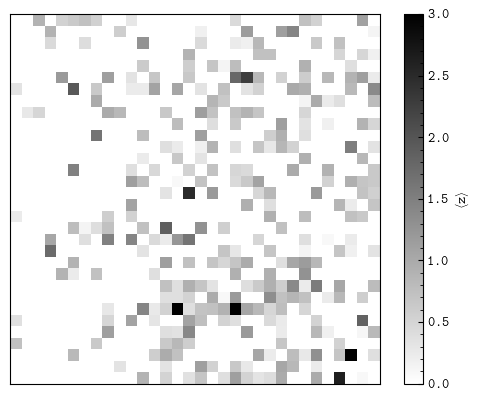

In [112]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    (
        np.sum(lib.const.ZVALS * nz, axis=1) 
        / np.sum(nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
    vmax=3,
)
fig.colorbar(m, label="$\\langle z \\rangle$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [113]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        assignments["noshear"][bhat == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

nz_tomo = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo[tomographic_bin] = np.nansum(
        nz[cell_assignments[tomographic_bin]] \
        * response_grid[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid[cell_assignments[tomographic_bin], np.newaxis],
        axis=0
    ) / np.nansum(
        response_grid[cell_assignments[tomographic_bin]] \
        * weight_grid[cell_assignments[tomographic_bin]]
    )
    # manually force n(0) = 0
    nz_tomo[tomographic_bin][0] = 0


/tmp/ipykernel_672650/2453250930.py:20: RuntimeWarning: invalid value encountered in divide
  np.sum(lib.const.ZVALS * _nz, axis=1)


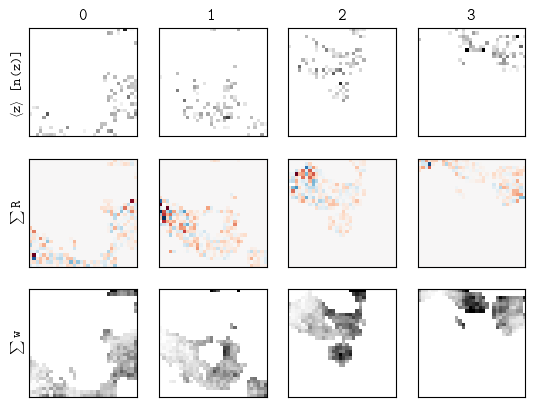

In [114]:
fig, axs = plt.subplots(3, len(lib.const.TOMOGRAPHIC_BINS), sharex=True, sharey=True)

nz_norm = mpl.colors.Normalize(vmin=0, vmax=3)
r_norm = mpl.colors.CenteredNorm()
w_norm = mpl.colors.Normalize(vmin=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz = np.zeros_like(nz)
    _r = np.zeros_like(nz)
    _w = np.zeros_like(nz)
    
    _nz[cell_assignments[tomographic_bin]] = nz[cell_assignments[tomographic_bin]]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)
        
    axs[0, tomographic_bin].imshow(
    (
        np.sum(lib.const.ZVALS * _nz, axis=1) 
        / np.sum(_nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
        norm=nz_norm,
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_r, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=r_norm,
        cmap="RdBu_r",
    )
    
    axs[2, tomographic_bin].imshow(
        np.sum(_w, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=w_norm,
    )

axs[0, 0].set_ylabel("$\\langle z \\rangle$ [$n(z)$]")
axs[1, 0].set_ylabel("$\\sum R$")
axs[2, 0].set_ylabel("$\\sum w$")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

/tmp/ipykernel_672650/2448599643.py:19: RuntimeWarning: invalid value encountered in divide
  np.sum(lib.const.ZVALS * _nz * _r * _w, axis=1)


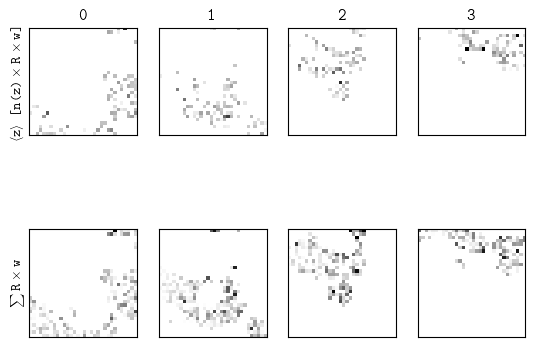

In [115]:
fig, axs = plt.subplots(2, len(lib.const.TOMOGRAPHIC_BINS), sharex=True, sharey=True)

nz_norm = mpl.colors.Normalize(vmin=0, vmax=3)
r_norm = mpl.colors.Normalize(vmin=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz = np.zeros_like(nz)
    _r = np.zeros_like(nz)
    _w = np.zeros_like(nz)
    
    _nz[cell_assignments[tomographic_bin]] = nz[cell_assignments[tomographic_bin]]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)
        
    axs[0, tomographic_bin].imshow(
    (
        np.sum(lib.const.ZVALS * _nz * _r * _w, axis=1) 
        / np.sum(_nz * _r * _w, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
        norm=nz_norm,
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_r * _w, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=r_norm,
    )


axs[0, 0].set_ylabel("$\\langle z \\rangle$ [$n(z) \\times R \\times w$]")
axs[1, 0].set_ylabel("$\\sum R \\times w$")


for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

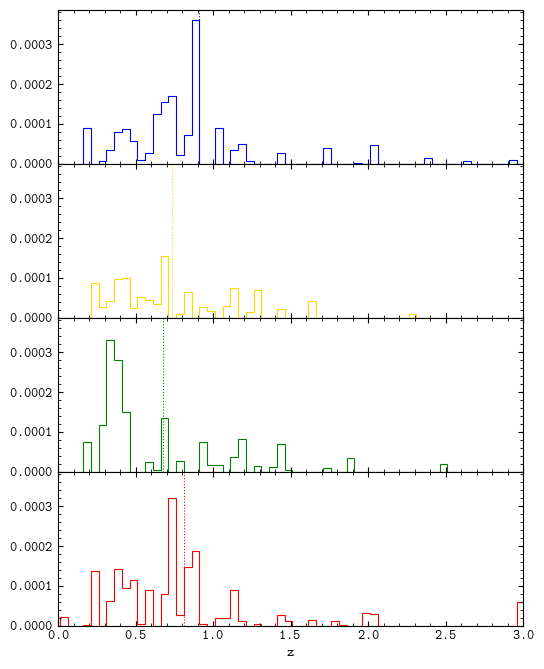

In [116]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

TOMO_COLORS = {
    0: "blue",
    1: "gold",
    2: "green",
    3: "red",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo[i]),
        c=TOMO_COLORS[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo[i],
        edges=lib.const.ZEDGES,
        ec=TOMO_COLORS[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

plt.show()